In [644]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import pickle
import joblib
from sklearn.svm import SVC

In [645]:
df = pd.read_csv("dataFinal.csv", delimiter=",")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19569 entries, 0 to 19568
Data columns (total 32 columns):
 #   Column                            Non-Null Count  Dtype
---  ------                            --------------  -----
 0   gender                            19569 non-null  int64
 1   age                               19569 non-null  int64
 2   education                         19569 non-null  int64
 3   work_status                       19569 non-null  int64
 4   injured_past_year                 19569 non-null  int64
 5   head_injury                       19569 non-null  int64
 6   chest_injury                      19569 non-null  int64
 7   back_injury                       19569 non-null  int64
 8   stomach_injury                    19569 non-null  int64
 9   upper_body_injury                 19569 non-null  int64
 10  lower_body_injury                 19569 non-null  int64
 11  bruises                           19569 non-null  int64
 12  cuts                            

In [646]:
df['emotional_mental_health_disorder'].value_counts()

emotional_mental_health_disorder
0    15875
1     3694
Name: count, dtype: int64

In [647]:
df_0 = df[df['emotional_mental_health_disorder'] == 0]
df_1 = df[df['emotional_mental_health_disorder'] == 1]

df_0_sample = df_0.sample(n=3100)
df_1_sample = df_1.sample(n=3100)

In [648]:
df_mental = pd.concat([df_0_sample, df_1_sample])

df_mental.sample(frac=1, random_state=42).reset_index(drop=True)

,gender,age,education,work_status,injured_past_year,head_injury,chest_injury,back_injury,stomach_injury,upper_body_injury,...,missing_body_parts,permanent_injury,place_of_injury,emotional_mental_health_disorder,has_injury,total_injuries,weighted_injury_severity,total_injury_severity,injured_body_parts_count,severe_injuries_count
0,1,51,3,5,1,1,2,2,1,2,...,2,2,2,1,1,16,91,28,16,12
1,2,67,3,1,1,2,2,1,2,2,...,2,2,2,0,1,16,98,30,16,14
2,1,35,4,1,1,2,2,2,2,2,...,2,2,5,0,1,16,98,30,16,14
3,1,35,5,8,1,2,2,2,2,1,...,2,2,2,1,1,16,97,29,16,13
4,2,53,1,6,1,2,2,2,2,1,...,2,2,2,0,1,16,99,30,16,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6195,2,62,3,1,1,2,2,2,2,2,...,2,2,2,1,1,16,99,30,16,14
6196,2,41,5,8,1,1,2,2,2,2,...,2,2,2,1,1,16,96,30,16,14
6197,2,57,1,1,1,2,2,2,2,1,...,2,2,2,1,1,16,99,30,16,14
6198,2,38,3,1,1,2,2,1,2,2,...,2,2,2,1,1,16,95,29,16,13


In [649]:
df['emotional_mental_health_disorder'].value_counts()

emotional_mental_health_disorder
0    15875
1     3694
Name: count, dtype: int64

In [650]:
X = df_mental.drop(['emotional_mental_health_disorder'], axis=1).values
y = df_mental['emotional_mental_health_disorder'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_resampled)
X_test_pca = pca.transform(X_test_scaled)

In [651]:
rf_model = RandomForestClassifier()   
rf_model.fit(X_train_pca, y_train_resampled)
rf_pred = rf_model.predict(X_test_pca)
rf_acc = accuracy_score(y_test, rf_pred) * 100

print(f"RF Accuracy: {rf_acc:.2f}")
print(classification_report(y_test, rf_pred))

RF Accuracy: 55.81
              precision    recall  f1-score   support

           0       0.57      0.54      0.56       953
           1       0.54      0.58      0.56       907

    accuracy                           0.56      1860
   macro avg       0.56      0.56      0.56      1860
weighted avg       0.56      0.56      0.56      1860



In [652]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train_pca, y_train_resampled)
xgb_pred = xgb_model.predict(X_test_pca)
xgb_acc = accuracy_score(y_test, xgb_pred) * 100

print(f"XGBoost Accuracy: {xgb_acc:.2f}%")
print(classification_report(y_test, xgb_pred))

c:\Users\phili\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:25:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 55.38%
              precision    recall  f1-score   support

           0       0.56      0.56      0.56       953
           1       0.54      0.54      0.54       907

    accuracy                           0.55      1860
   macro avg       0.55      0.55      0.55      1860
weighted avg       0.55      0.55      0.55      1860



In [653]:
lr_model = LogisticRegression()
lr_model.fit(X_train_pca, y_train_resampled)
lr_pred = lr_model.predict((X_test_pca))
lr_acc = accuracy_score(y_test, lr_pred) * 100

print(f"Logistic Regression Accuracy: {lr_acc:.2f}")
print(classification_report(y_test, lr_pred))

Logistic Regression Accuracy: 58.87
              precision    recall  f1-score   support

           0       0.59      0.63      0.61       953
           1       0.58      0.55      0.56       907

    accuracy                           0.59      1860
   macro avg       0.59      0.59      0.59      1860
weighted avg       0.59      0.59      0.59      1860



In [654]:
mlp_model = MLPClassifier()
mlp_model.fit(X_train_pca, y_train_resampled)
mlp_pred = mlp_model.predict(X_test_pca)
mlp_acc = accuracy_score(y_test, mlp_pred) * 100

print(f"NN Accuracy: {mlp_acc:.2f}")
print(classification_report(y_test, mlp_pred))

NN Accuracy: 56.45
              precision    recall  f1-score   support

           0       0.57      0.59      0.58       953
           1       0.56      0.53      0.54       907

    accuracy                           0.56      1860
   macro avg       0.56      0.56      0.56      1860
weighted avg       0.56      0.56      0.56      1860



c:\Users\phili\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [655]:
svm_model = SVC()
svm_model.fit(X_train_pca, y_train_resampled)
svm_pred = svm_model.predict(X_test_pca)
svm_acc = accuracy_score(y_test, svm_pred) * 100

print(f"SVM Accuracy: {svm_acc:.2f}")
print(classification_report(y_test, svm_pred))

SVM Accuracy: 58.28
              precision    recall  f1-score   support

           0       0.60      0.56      0.58       953
           1       0.57      0.61      0.59       907

    accuracy                           0.58      1860
   macro avg       0.58      0.58      0.58      1860
weighted avg       0.58      0.58      0.58      1860



In [656]:
knn_model = KNeighborsClassifier()
knn_model.fit(X_train_pca, y_train_resampled)
knn_pred = knn_model.predict(X_test_pca)
knn_acc = accuracy_score(y_test, knn_pred) * 100

print(f"k-NN Accuracy: {knn_acc:.2f}")
print(classification_report(y_test, knn_pred))

k-NN Accuracy: 54.78
              precision    recall  f1-score   support

           0       0.56      0.55      0.55       953
           1       0.54      0.55      0.54       907

    accuracy                           0.55      1860
   macro avg       0.55      0.55      0.55      1860
weighted avg       0.55      0.55      0.55      1860



In [657]:
print(f"Accuracy Scores:\nLogistic Regression: {lr_acc:.2f}\nXGBoost: {xgb_acc:.2f}\nRandom Forest: {rf_acc:.2f}\nNeural Network: {mlp_acc:.2f}\nSVM: {svm_acc:.2f}\nk-NN: {knn_acc:.2f}")

Accuracy Scores:
Logistic Regression: 58.87
XGBoost: 55.38
Random Forest: 55.81
Neural Network: 56.45
SVM: 58.28
k-NN: 54.78


In [658]:
# def pickleModel(model, filename):
#     pickle.dump(model, open(filename, 'wb'))

# pickleModel(rf_model, 'models/RF.pkl')
# pickleModel(xgb_model, 'models/XGB.pkl')
# pickleModel(lr_model, 'models/LR.pkl')
# pickleModel(mlp_model, 'models/NN.pkl')
# pickleModel(svm_model, 'models/SVM.pkl')
# pickleModel(knn_model, 'models/KNN.pkl')

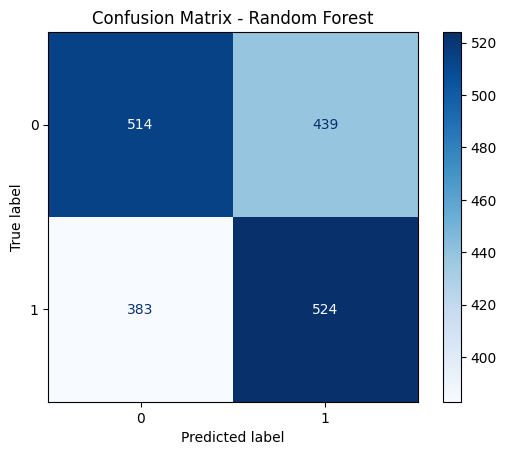

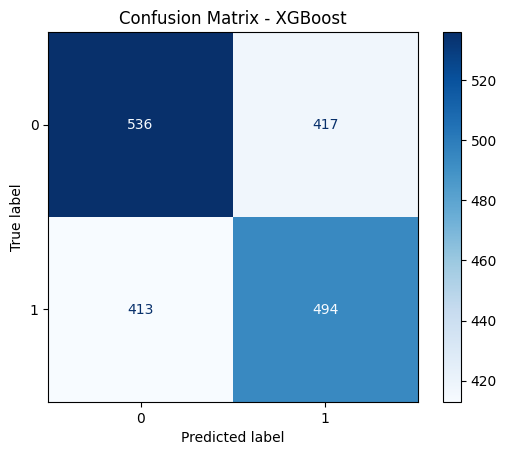

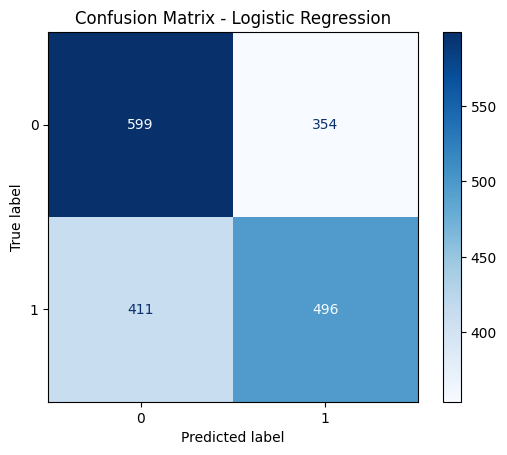

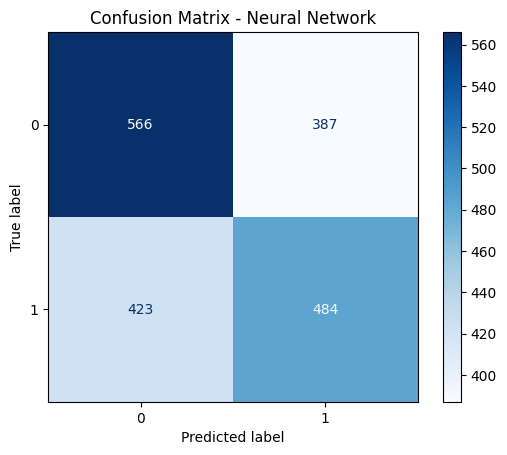

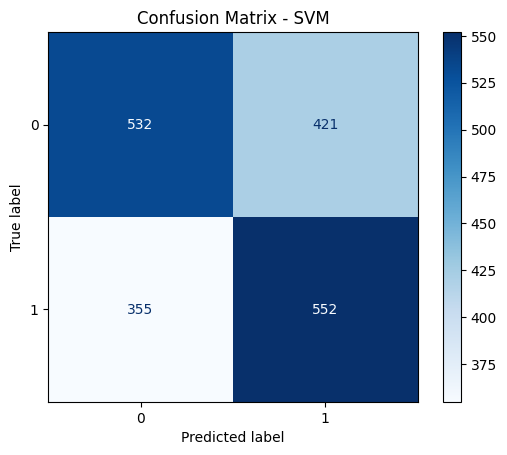

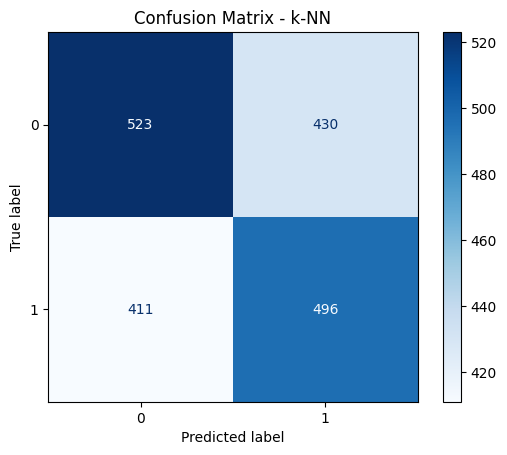

In [659]:
def plot_confusion_matrix(y_test, y_pred, model_name):
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

plot_confusion_matrix(y_test, rf_pred, "Random Forest")
plot_confusion_matrix(y_test, xgb_pred, "XGBoost")
plot_confusion_matrix(y_test, lr_pred, "Logistic Regression")
plot_confusion_matrix(y_test, mlp_pred, "Neural Network")
plot_confusion_matrix(y_test, svm_pred, "SVM")
plot_confusion_matrix(y_test, knn_pred, "k-NN")

In [660]:

# top_5_features = feature_importances.nlargest(5, "Importance")["Feature"]

# fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 6), sharey=True)

# for i, feature in enumerate(top_5_features):
#     grouped_df = df.groupby(feature)[target_variable].value_counts(normalize=True).unstack()
    
#     grouped_df.plot(kind='bar', stacked=True, ax=axes[i], colormap="coolwarm", alpha=0.85)
    
#     axes[i].set_title(feature)
#     axes[i].set_xlabel("")
#     axes[i].set_ylabel("Proportion")
#     axes[i].legend(title="Emotional Mental Health Disorder", labels=["0 (No)", "1 (Yes)"])

# plt.tight_layout()
# plt.show()

